# Feedforward Neural Networks (FNNs)

Feedforward Neural Networks (FNNs) are one of the simplest types of artificial neural networks. They are composed of layers of neurons where the connections between the nodes do not form a cycle. In this project, we implement an FNN model to predict diabetes based on a structured dataset.

The model architecture includes several fully connected (dense) layers, with batch normalization and dropout applied for regularization. Below, we outline the steps involved in building, training, and evaluating our FNN model.

## 1. Importing Necessary Libraries

To begin, we import the required libraries, including TensorFlow and Keras for building the neural network, as well as other libraries for data preprocessing and evaluation.

In [1]:
# Importing necessary libraries
import tensorflow as tf
from keras.api import layers, models, regularizers
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner.tuners import RandomSearch

# Enable GPU for training
if tf.test.gpu_device_name():
    print('Default GPU Device:', tf.test.gpu_device_name())
else:
    print("Please install GPU version of TF")


2024-08-18 21:38:12.211669: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-18 21:38:12.221931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 21:38:12.233885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 21:38:12.237269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 21:38:12.246166: I tensorflow/core/platform/cpu_feature_guar

Default GPU Device: /device:GPU:0


I0000 00:00:1723988294.133132   37552 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723988294.157125   37552 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723988294.157321   37552 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723988294.215055   37552 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## 2. Load and Prepare the Dataset

In this step, we load the dataset, handle any missing values, and prepare the feature set and target variable for training. We also standardize the features to ensure the model trains effectively.

In [2]:
# Load and prepare the dataset
data = pd.read_csv('cleaned_diabetes_dataset.csv')

# Handle missing values if any
data['gender'] = data['gender'].fillna(data['gender'].mode()[0])

# Define the feature set (X) and target variable (y)
log_cols = ['log_bmi', 'log_HbA1c_level', 'log_blood_glucose_level']
X = data[log_cols + ['gender', 'smoking_history', 'hypertension', 'heart_disease']]
y = data['diabetes']

# One-hot encode the target variable for categorical crossentropy
y = tf.keras.utils.to_categorical(y, num_classes=2)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## 3. Defining the Feedforward Neural Network (FNN) Model

Here, we define the architecture of the FNN model. The model consists of multiple dense layers with ReLU activation, along with batch normalization and dropout for regularization.

In [3]:
# Define an improved FNN model
model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


/home/abdallah/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1723988302.591903   37552 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723988302.592220   37552 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723988302.592373   37552 cuda

## 4. Model Training with Early Stopping

In this section, we train the FNN model using the training data. Early stopping and learning rate reduction on plateau are employed to prevent overfitting and optimize the training process.

In [4]:
# Train the model with early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(X_train, y_train, 
                    epochs=25, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/25


I0000 00:00:1723988308.557958   37717 service.cc:146] XLA service 0x757a40006dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723988308.557995   37717 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-08-18 21:38:28.606789: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-18 21:38:28.811417: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


  48/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4916 - loss: 1.4226

I0000 00:00:1723988310.867288   37717 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8629 - loss: 0.5934 - val_accuracy: 0.9615 - val_loss: 0.2137 - learning_rate: 0.0010
Epoch 2/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9534 - loss: 0.2096 - val_accuracy: 0.9617 - val_loss: 0.1395 - learning_rate: 0.0010
Epoch 3/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9589 - loss: 0.1570 - val_accuracy: 0.9676 - val_loss: 0.1231 - learning_rate: 0.0010
Epoch 4/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9618 - loss: 0.1430 - val_accuracy: 0.9675 - val_loss: 0.1233 - learning_rate: 0.0010
Epoch 5/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9630 - loss: 0.1389 - val_accuracy: 0.9653 - val_loss: 0.1208 - learning_rate: 0.0010
Epoch 6/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9642 - loss: 0.1352 - val_accuracy: 0.9686 - val_loss: 0.1245 - learning_rate: 0.0010
Epoch 7/25
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9660 - loss:

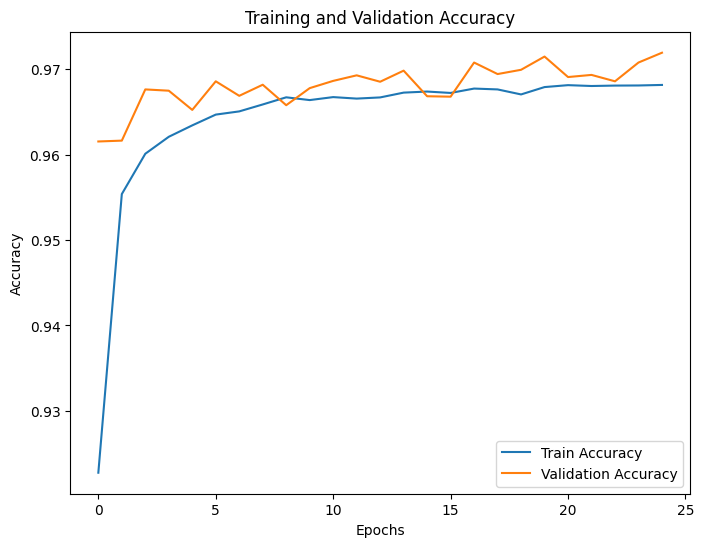

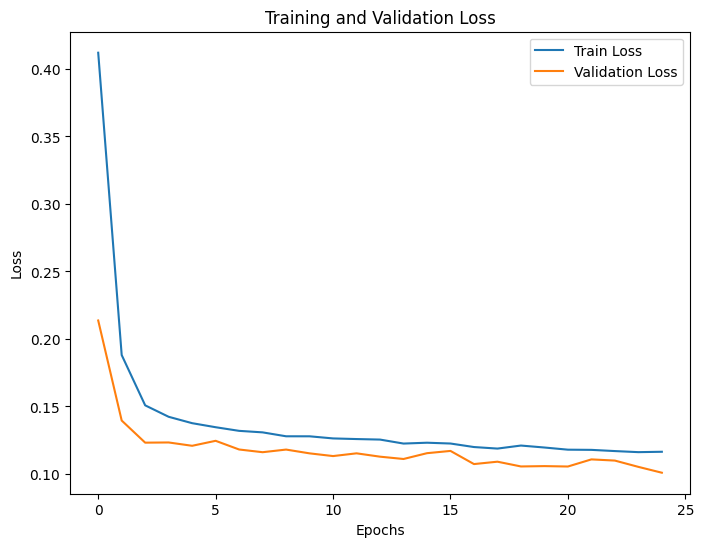

In [7]:
# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5. Evaluate the Model Performance

After training, we evaluate the model's performance on the test set. Various metrics, including accuracy, confusion matrix, and ROC curve, are calculated and visualized.

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9716 - loss: 0.1017
Test accuracy: 0.9719
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       1.00      0.67      0.80      1708

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



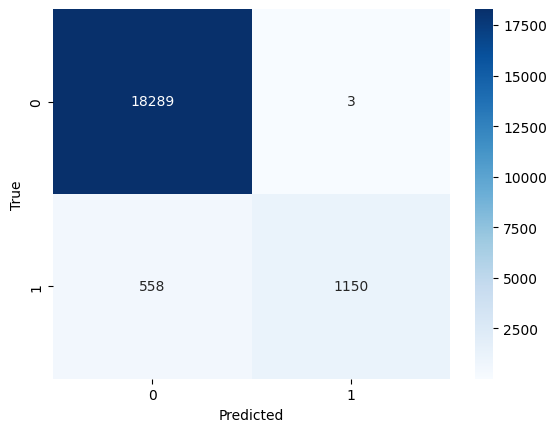

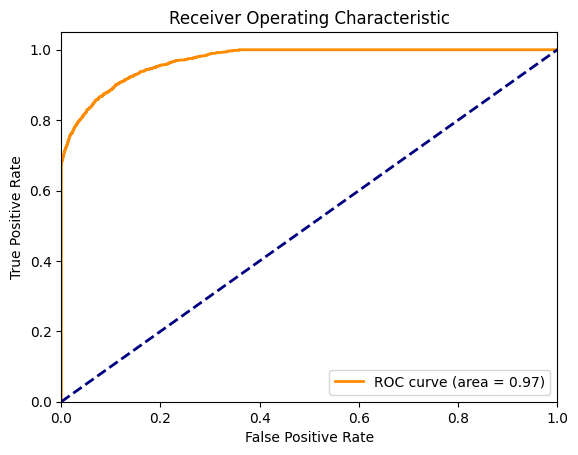

In [8]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


## 6. Hyperparameter Tuning with Keras Tuner

To optimize the performance of our FNN model, we use Keras Tuner to perform hyperparameter tuning. This involves searching for the best combination of hyperparameters, such as the number of units in each layer, dropout rate, and learning rate.

In [9]:
# Hyperparameter tuning with Keras Tuner

# Define a function to build the FNN model
def build_fnn_model(hp):
    model = models.Sequential()
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                           activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int(f'layer_{i}_units', min_value=32, max_value=512, step=32),
                               activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float(f'layer_{i}_dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Initialize the RandomSearch tuner
tuner = RandomSearch(build_fnn_model,
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial=1,
                     directory='fnn_tuning',
                     project_name='diabetes_classification')

# Run the hypertuning process
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best number of units: {best_hps.get("units")}')
print(f'Best dropout rate: {best_hps.get("dropout")}')
print(f'Best learning rate: {best_hps.get("learning_rate")}')


Trial 10 Complete [00h 01m 32s]
val_accuracy: 0.9714499711990356

Best val_accuracy So Far: 0.9718000292778015
Total elapsed time: 00h 17m 09s
Best number of units: 256
Best dropout rate: 0.30000000000000004
Best learning rate: 0.0005138473190043693


## 7. Evaluate the Tuned Model Performance

After determining the best hyperparameters using Keras Tuner, we evaluate the performance of the tuned FNN model on the test dataset. We assess the accuracy, confusion matrix, and ROC curve to understand the model's effectiveness.

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8807 - loss: 0.3223 - val_accuracy: 0.9609 - val_loss: 0.1126 - learning_rate: 5.1385e-04
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9557 - loss: 0.1340 - val_accuracy: 0.9604 - val_loss: 0.1125 - learning_rate: 5.1385e-04
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9596 - loss: 0.1214 - val_accuracy: 0.9647 - val_loss: 0.1031 - learning_rate: 5.1385e-04
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9627 - loss: 0.1136 - val_accuracy: 0.9682 - val_loss: 0.0963 - learning_rate: 5.1385e-04
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9665 - loss: 0.1046 - val_accuracy: 0.9681 - val_loss: 0.0991 - learning_rate: 5.1385e-04
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9682 - loss: 0.1009 - val_accuracy: 0.9706 - val_loss: 0.0903 - learning_rate: 5.1385e-04
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 

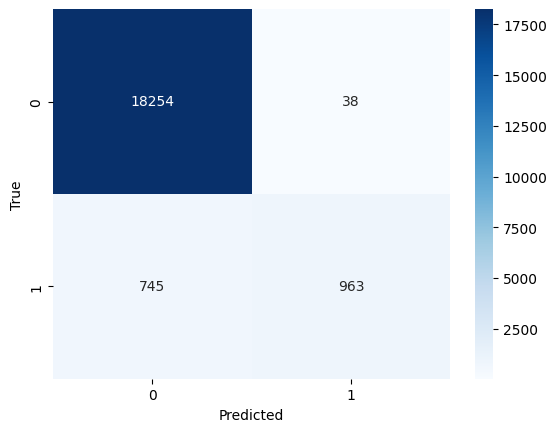

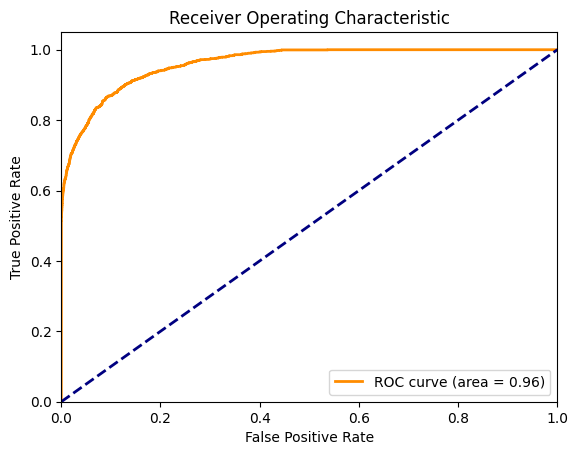

In [11]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, 
                         epochs=30, 
                         validation_data=(X_test, y_test), 
                         callbacks=[early_stopping, reduce_lr])

# Evaluate the tuned model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# Predict on the test set with the tuned model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report for the tuned model
print(classification_report(y_true, y_pred_classes))

# Confusion matrix for the tuned model
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC curve for the tuned model
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
